In [72]:
# Install required packages
!pip install huggingface_hub matplotlib pandas seaborn -q

In [73]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from huggingface_hub import snapshot_download

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [74]:
# Configuration
REPO_ID = "VohraAK/canine-s-uqa-filtered"
REPO_NAME = REPO_ID.split("/")[-1]  # Extract repo name from REPO_ID
LOCAL_DIR = f"checkpoints/{REPO_NAME}"

print(f"📥 Downloading checkpoints from {REPO_ID}...")
print(f"📁 Saving to: {LOCAL_DIR}")

# Download all checkpoints
local_path = snapshot_download(
    repo_id=REPO_ID,
    repo_type="model",
    local_dir=LOCAL_DIR,
    allow_patterns="checkpoint-*/trainer_state.json"  # Only download trainer_state.json files
)

📥 Downloading checkpoints from VohraAK/canine-s-uqa-filtered...
📁 Saving to: checkpoints/canine-s-uqa-filtered


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [75]:
# Collect all checkpoints (sorted by numeric suffix) and print summary
def _cp_num(p):
    try:
        return int(p.name.split("-")[-1])
    except Exception:
        return -1

checkpoint_dirs = sorted(
    [d for d in Path(LOCAL_DIR).glob("checkpoint-*") if d.is_dir()],
    key=_cp_num
)

if not checkpoint_dirs:
    print(f"❌ No checkpoints found in {LOCAL_DIR}")
else:
    print(f"✅ Found {len(checkpoint_dirs)} checkpoints. Latest: {checkpoint_dirs[-1].name}")
    for cp in checkpoint_dirs:
        print(f"  - {cp.name}")

✅ Found 15 checkpoints. Latest: checkpoint-14662
  - checkpoint-1000
  - checkpoint-2000
  - checkpoint-3000
  - checkpoint-4000
  - checkpoint-5000
  - checkpoint-6000
  - checkpoint-7000
  - checkpoint-8000
  - checkpoint-9000
  - checkpoint-10000
  - checkpoint-11000
  - checkpoint-12000
  - checkpoint-13000
  - checkpoint-14000
  - checkpoint-14662


In [76]:
def extract_metrics_from_checkpoint(checkpoint_path):
    """
    Extract training loss and evaluation metrics from trainer_state.json
    """
    trainer_state_path = checkpoint_path / "trainer_state.json"
    
    if not trainer_state_path.exists():
        print(f"⚠️  Warning: {trainer_state_path} not found")
        return None
    
    with open(trainer_state_path, 'r') as f:
        state = json.load(f)
    
    log_history = state.get('log_history', [])
    
    # Extract training losses
    train_losses = [
        {'step': entry.get('step'), 'loss': entry.get('loss')}
        for entry in log_history
        if 'loss' in entry
    ]
    
    # Extract evaluation metrics
    eval_metrics = [
        {
            'step': entry.get('step'),
            'exact_match': entry.get('eval_exact_match'),
            'f1': entry.get('eval_f1'),
            'edit_distance': entry.get('eval_edit_distance')
        }
        for entry in log_history
        if 'eval_exact_match' in entry or 'eval_f1' in entry
    ]
    
    return {
        'checkpoint': checkpoint_path.name,
        'global_step': state.get('global_step'),
        'train_losses': train_losses,
        'eval_metrics': eval_metrics
    }


# Extract metrics from all checkpoints
all_metrics = []
for cp_dir in checkpoint_dirs:
    metrics = extract_metrics_from_checkpoint(cp_dir)
    if metrics:
        all_metrics.append(metrics)

print(f"\n✅ Extracted metrics from {len(all_metrics)} checkpoints")


✅ Extracted metrics from 15 checkpoints


In [77]:
metrics

{'checkpoint': 'checkpoint-14662',
 'global_step': 14662,
 'train_losses': [{'step': 50, 'loss': 5.9451},
  {'step': 100, 'loss': 5.9024},
  {'step': 150, 'loss': 5.8675},
  {'step': 200, 'loss': 5.8366},
  {'step': 250, 'loss': 5.7987},
  {'step': 300, 'loss': 5.7744},
  {'step': 350, 'loss': 5.7348},
  {'step': 400, 'loss': 5.7044},
  {'step': 450, 'loss': 5.662},
  {'step': 500, 'loss': 5.6318},
  {'step': 550, 'loss': 5.6124},
  {'step': 600, 'loss': 5.5747},
  {'step': 650, 'loss': 5.5551},
  {'step': 700, 'loss': 5.5417},
  {'step': 750, 'loss': 5.52},
  {'step': 800, 'loss': 5.4724},
  {'step': 850, 'loss': 5.44},
  {'step': 900, 'loss': 5.414},
  {'step': 950, 'loss': 5.386},
  {'step': 1000, 'loss': 5.3722},
  {'step': 1050, 'loss': 5.3611},
  {'step': 1100, 'loss': 5.3192},
  {'step': 1150, 'loss': 5.2914},
  {'step': 1200, 'loss': 5.2673},
  {'step': 1250, 'loss': 5.2435},
  {'step': 1300, 'loss': 5.2601},
  {'step': 1350, 'loss': 5.1841},
  {'step': 1400, 'loss': 5.1746},
 

In [78]:
# Combine all training losses
all_train_losses = []
for metrics in all_metrics:
    all_train_losses.extend(metrics['train_losses'])

# Combine all eval metrics
all_eval_metrics = []
for metrics in all_metrics:
    all_eval_metrics.extend(metrics['eval_metrics'])

# Convert to DataFrames
df_loss = pd.DataFrame(all_train_losses).dropna()
df_eval = pd.DataFrame(all_eval_metrics).dropna()

print("Training Loss Data:")
print(df_loss.head())
print(f"\nShape: {df_loss.shape}")

print("\n" + "="*50)
print("\nEvaluation Metrics Data:")
print(df_eval.head())
print(f"\nShape: {df_eval.shape}")

Training Loss Data:
   step    loss
0    50  5.9451
1   100  5.9024
2   150  5.8675
3   200  5.8366
4   250  5.7987

Shape: (2393, 2)


Evaluation Metrics Data:
   step  exact_match        f1  edit_distance
0  1000     0.000375  0.012993       0.040094
1  1000     0.000375  0.012993       0.040094
2  2000     0.000250  0.008342       0.026251
3  1000     0.000375  0.012993       0.040094
4  2000     0.000250  0.008342       0.026251

Shape: (120, 4)


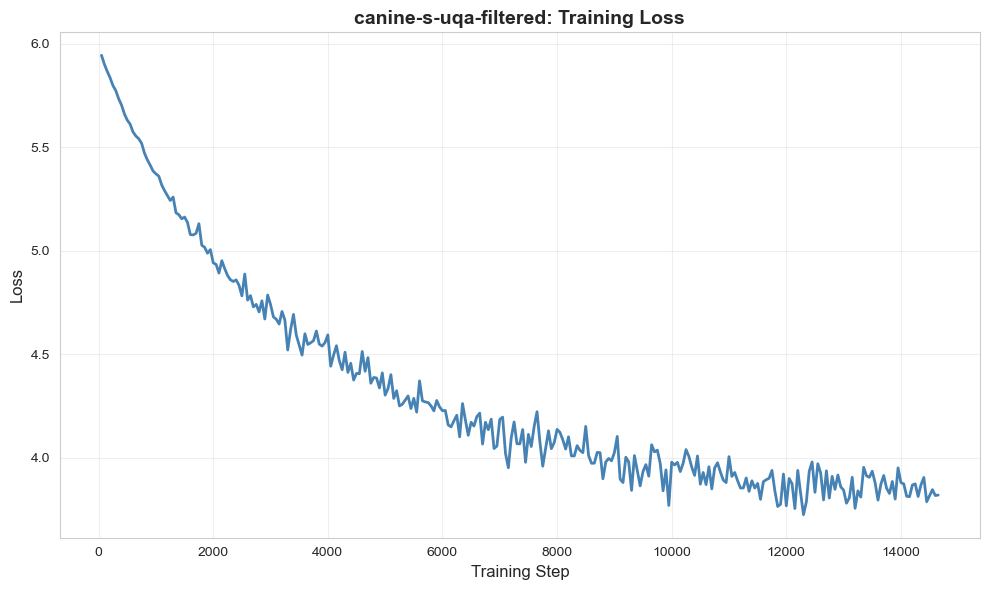

In [79]:
# Simple individual plots - Training Loss
if not df_loss.empty:
    plt.figure(figsize=(10, 6))
    df_loss_sorted = df_loss.sort_values('step')
    plt.plot(df_loss_sorted['step'], df_loss_sorted['loss'], linewidth=2, color='steelblue')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'{REPO_NAME}: Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️  No training loss data")

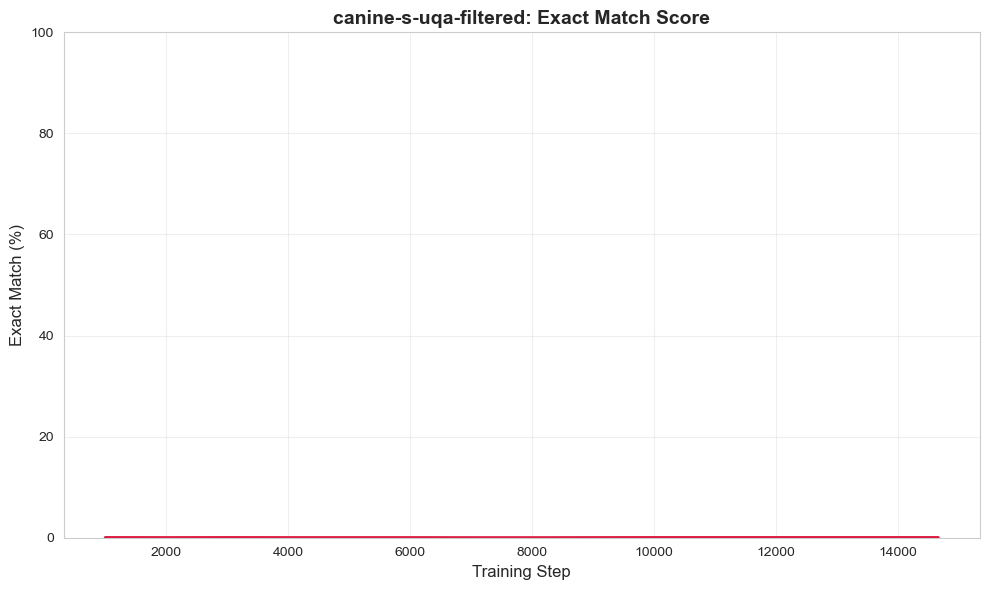

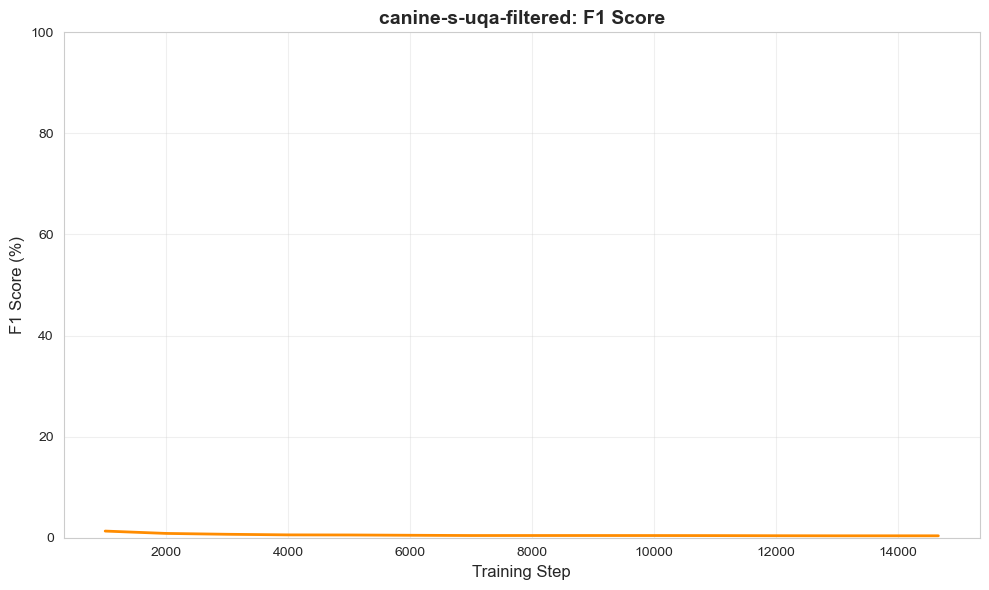

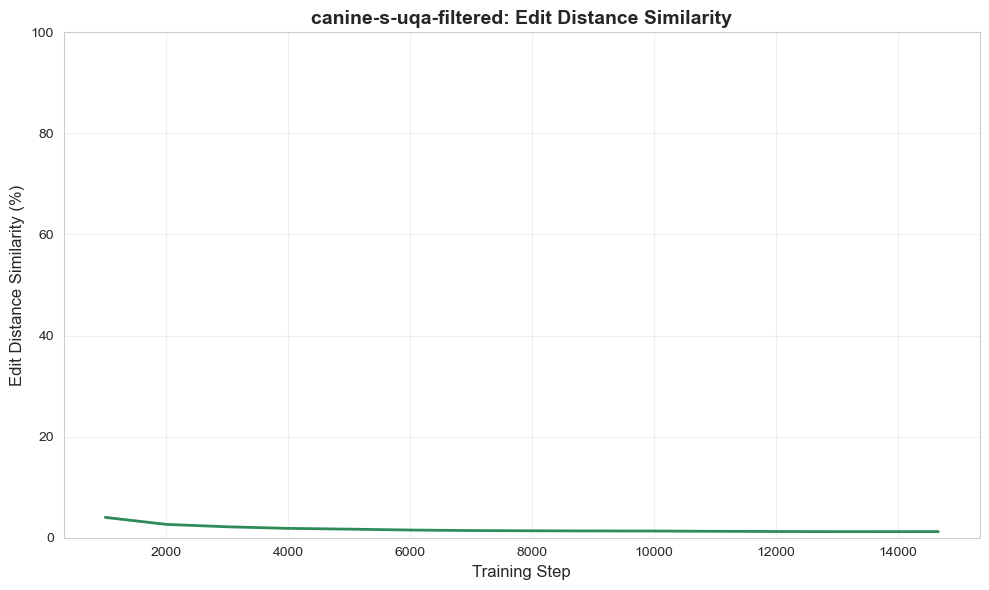

In [80]:
# Simple individual plots - Exact Match
if not df_eval.empty and 'exact_match' in df_eval.columns:
    plt.figure(figsize=(10, 6))
    df_eval_sorted = df_eval.sort_values('step')
    plt.plot(df_eval_sorted['step'], df_eval_sorted['exact_match'] * 100, linewidth=2, color='crimson')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Exact Match (%)', fontsize=12)
    plt.title(f'{REPO_NAME}: Exact Match Score', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No Exact Match data")

# Simple individual plots - F1 Score
if not df_eval.empty and 'f1' in df_eval.columns:
    plt.figure(figsize=(10, 6))
    df_eval_sorted = df_eval.sort_values('step')
    plt.plot(df_eval_sorted['step'], df_eval_sorted['f1'] * 100, linewidth=2, color='darkorange')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('F1 Score (%)', fontsize=12)
    plt.title(f'{REPO_NAME}: F1 Score', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No F1 Score data")

# Simple individual plots - Edit Distance
if not df_eval.empty and 'edit_distance' in df_eval.columns:
    plt.figure(figsize=(10, 6))
    df_eval_sorted = df_eval.sort_values('step')
    plt.plot(df_eval_sorted['step'], df_eval_sorted['edit_distance'] * 100, linewidth=2, color='seagreen')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Edit Distance Similarity (%)', fontsize=12)
    plt.title(f'{REPO_NAME}: Edit Distance Similarity', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No Edit Distance data")

---